# Modeling

## Importing modules and data

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.decomposition import PCA


%matplotlib inline
sns.set_style('darkgrid')

In [2]:
np.random.seed(32)

In [3]:
df = pd.read_csv('../data/train_weather_spray_merged.csv')

In [4]:
df_dummied = pd.get_dummies(df, columns=['species'])

## Creating Validation Set, Scaling

In [5]:
df_dummied.drop(columns=['date', 'address', 'block', 'street', 'trap', 'addressnumberandstreet', 'nummosquitos', 'sunrise', 'sunset'], axis=1, inplace=True)

In [6]:
features = [col for col in df_dummied if col != 'wnvpresent']

In [7]:
df_dummied.columns

Index(['latitude', 'longitude', 'addressaccuracy', 'wnvpresent',
       'spray_nearby', 'station', 'tmax', 'tmin', 'tavg', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'tsra', 'sn', 'br', 'vcfg',
       'bcfg', 'hz', 'ra', 'dz', 'gr', 'mifg', 'sq', 'fg', 'ts', 'fg+', 'vcts',
       'fu', 'species_CULEX OTHER', 'species_CULEX PIPIENS',
       'species_CULEX PIPIENS/RESTUANS', 'species_CULEX RESTUANS'],
      dtype='object')

In [8]:
X = df_dummied[features]
y = df_dummied.wnvpresent

In [9]:
X.columns

Index(['latitude', 'longitude', 'addressaccuracy', 'spray_nearby', 'station',
       'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'tsra', 'sn', 'br', 'vcfg', 'bcfg', 'hz', 'ra', 'dz', 'gr',
       'mifg', 'sq', 'fg', 'ts', 'fg+', 'vcts', 'fu', 'species_CULEX OTHER',
       'species_CULEX PIPIENS', 'species_CULEX PIPIENS/RESTUANS',
       'species_CULEX RESTUANS'],
      dtype='object')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)

In [11]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [12]:
with open('../models/scaler.pkl', 'wb') as file:
    pickle.dump(ss, file)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [14]:
pca = PCA(n_components=7)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [192]:
with open('../models/pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

## Logistic Regression

In [15]:
lr = LogisticRegression()

params = {
    'penalty':['l1', 'l2'],
    'C':np.logspace(start=-5, stop=-1, num=10000),
    'class_weight':['balanced'],
}
gs_lr = GridSearchCV(lr, param_grid=params, return_train_score=True, scoring='roc_auc')
gs_lr.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.00000e-05, 1.00092e-05, ..., 9.99079e-02, 1.00000e-01]), 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [98]:
session_results = {
    'l1':{'train':[],'test':[]},
    'l2':{'train':[],'test':[]},
}
m_test_s = gs_lr.cv_results_['mean_test_score']
m_train_s = gs_lr.cv_results_['mean_train_score']

for index, session in enumerate(gs_lr.cv_results_['params']):
    penalty = session['penalty']
    session_results[penalty]['train'].append(m_train_s[index])
    session_results[penalty]['test'].append(m_test_s[index])

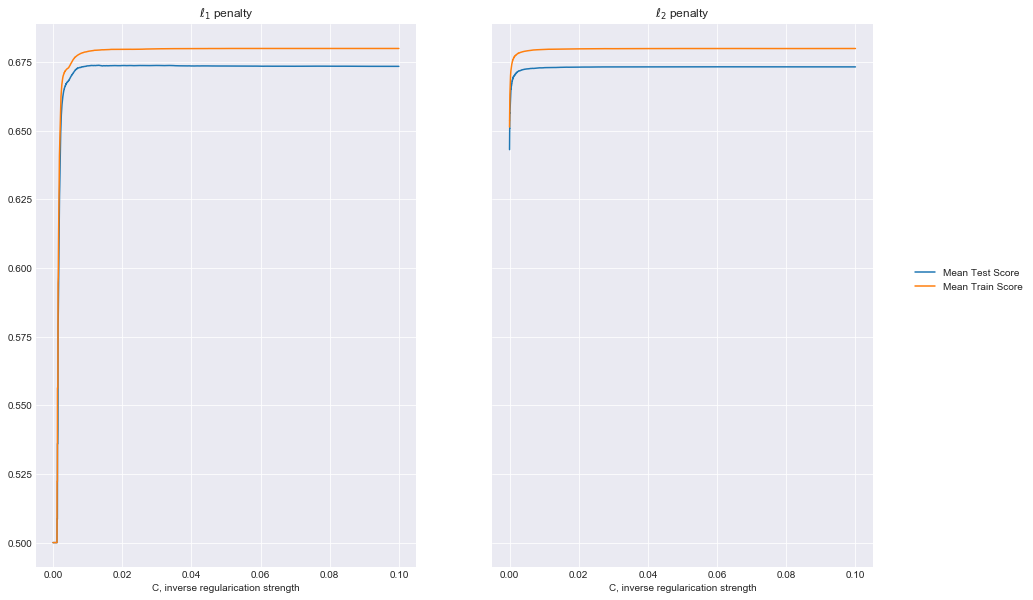

In [121]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,10), sharey=True)

mtest_l1, mtrain_l1 = session_results['l1']['test'], session_results['l1']['train']
ax[0].plot(params['C'], mtest_l1, label='Mean Test Score')
ax[0].plot(params['C'], mtrain_l1, label='Mean Train Score')
ax[0].set_title('$\ell_1$ penalty')
ax[0].set_xlabel('C, inverse regularication strength')

mtest_l2, mtrain_l2 = session_results['l2']['test'], session_results['l2']['train']
ax[1].plot(params['C'], mtest_l2, label='Mean Test Score')
ax[1].plot(params['C'], mtrain_l2, label='Mean Train Score')
ax[1].set_title('$\ell_2$ penalty')
ax[1].set_xlabel('C, inverse regularication strength')
ax[1].legend(loc=(1.1,.5))




In [122]:
gs_lr.score(X_train, y_train), gs_lr.score(X_test, y_test)

(0.6791872401075764, 0.6920100572309734)

In [123]:
gs_lr.best_params_

{'C': 0.013301860569649207, 'class_weight': 'balanced', 'penalty': 'l1'}

In [178]:
model_file = 'log_reg.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_lr, file)

Similar results with $\ell_1$ and $\ell_2$ regularization, with a slight advantage to $\ell_1$. Not much evidence of overfitting in comparing the training and test scores.

## AdaBoost w/Logistic Regression base

In [140]:
np.random.seed(41)
ada = AdaBoostClassifier()
params = {
        'base_estimator':[LogisticRegression(class_weight='balanced')],
        'n_estimators': [10**5],
}
gs_ada = GridSearchCV(ada, param_grid=params, scoring='roc_auc', verbose=1, return_train_score=True,)

%time gs_ada.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.9s finished


CPU times: user 32.4 s, sys: 406 ms, total: 32.8 s
Wall time: 17.1 s


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'base_estimator': [LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

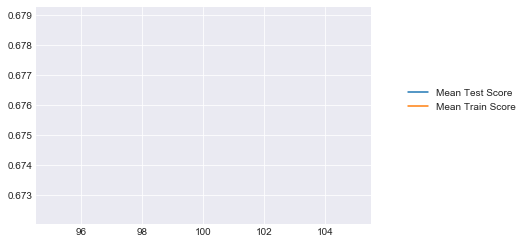

In [141]:
mtest, mtrain = gs_ada.cv_results_['mean_test_score'], gs_ada.cv_results_['mean_train_score']
plt.plot(params['n_estimators'], mtest, label='Mean Test Score')
plt.plot(params['n_estimators'], mtrain, label='Mean Train Score')
plt.legend(loc=(1.1, .5))


In [142]:
gs_ada.best_params_

{'base_estimator': LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'n_estimators': 100}

In [143]:
gs_ada.score(X_train, y_train), gs_ada.score(X_test, y_test)

(0.678157247134909, 0.690105192739972)

In [177]:
model_file = 'ada.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_ada, file)

## Bagging

In [171]:
np.random.seed(41)

bag = BaggingClassifier()
params = {
    'n_estimators': range(1,201, 10),
}
gs_bag = GridSearchCV(bag, param_grid = params, scoring='roc_auc', verbose=1, return_train_score=True)
%time gs_bag.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.4min finished


CPU times: user 2min 45s, sys: 1.99 s, total: 2min 47s
Wall time: 3min 27s


GridSearchCV(cv=None, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(1, 201, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

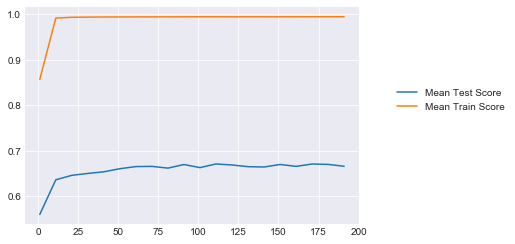

In [172]:
mtest, mtrain = gs_bag.cv_results_['mean_test_score'], gs_bag.cv_results_['mean_train_score']
plt.plot(params['n_estimators'], mtest, label='Mean Test Score')
plt.plot(params['n_estimators'], mtrain, label='Mean Train Score')
plt.legend(loc=(1.1, .5))


In [173]:
gs_bag.best_params_

{'n_estimators': 111}

In [174]:
gs_bag.score(X_train, y_train), gs_bag.score(X_test, y_test)

(0.992799460797523, 0.7570348176347366)

In [176]:
model_file = 'bag.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_bag, file)

There is a huge gulf between the testing and training scores for the bagged trees, this model is highly overfit.

## KNN

In [187]:
knn = KNeighborsClassifier()
params = {
    'n_neighbors': range(2,100),  
    'weights':['uniform']
}
gs_knn = GridSearchCV(knn, param_grid = params, scoring='roc_auc', verbose=1, return_train_score=True)
gs_knn.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  1.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(2, 100), 'weights': ['uniform']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

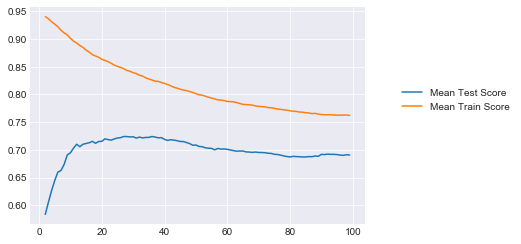

In [189]:
mtest, mtrain = gs_knn.cv_results_['mean_test_score'], gs_knn.cv_results_['mean_train_score']
plt.plot(params['n_neighbors'], mtest, label='Mean Test Score')
plt.plot(params['n_neighbors'], mtrain, label='Mean Train Score')
plt.legend(loc=(1.1, .5))


In [190]:
gs_knn.best_params_

{'n_neighbors': 27, 'weights': 'uniform'}

In [191]:
gs_knn.score(X_train, y_train), gs_knn.score(X_test, y_test)

(0.8542807617522892, 0.7655089134618929)

In [188]:
model_file = 'knn.pkl'
with open(f'../models/{model_file}', 'wb') as file:
    pickle.dump(gs_knn, file)

Very bizarre behavior in the training and testing scores, test score is increasing for (approximately) k between 1 and 25, then decreasing while training scores is strictly decreasing. 

## Summary

The vanilla Logistic Regression with $\ell_1$ regularization is the best of these models. It shows little evidence of overfit, is very fast, small and we will use the learned parameters later to infer importances of the the combined features resulting from PCA. 